In [1]:
"""
Created on Mon Feb 17 21:18:22 2020
The following notebook analyzes data from the AirBnB platform and is 
used for submission for the Data Science Blog project as part of the Udacity 
Nanodegree program. The data used is included in the form of CSV files.
@author: Repoman
"""
#CRISProcess | Business Understanding
#The questions from possible stakeholders that I would like to answer in the 
#context of this notebook are as follows.
#
#First business question:
#In order to achieve targeted marketing, it should be analyzed how the current price 
#is distributed in relation to the individual city districts in order to place 
#advertisements for highlights of individual city districts online in order to 
#show the number of bookings in these areas.
#How does the current booking distribution of rooms in order to neighboorhoods in Boston 
#look like in 2019 and 2018?
#What is the mean price of the two most booked neighboorhoods in Boston in 2019?

#Second business question:
#The second business question: How did the average price for the individual room types 
#develop from 2018 to 2019? The market potential can be derived here.

#The third business question:
#Is it possible to derive the price from the previous data based on the room type and month? 
#The customer behavior and the market situation can be derived from this.
#Is it possible to predict the price development for a room type?
#Questions of a marketing department could be: In which district 
#should we advertise more or what types of rooms should we also market social platforms more?

#To answer this questions we will use some libs
import numpy as np #mathematics lib
import pandas as pd #datastrucutr lib
import matplotlib.pyplot as plt #vis lib
from sklearn.linear_model import LinearRegression #machine learning lib
from sklearn.model_selection import train_test_split #for the machine learning training
from sklearn.metrics import r2_score, mean_squared_error #for the model evaluation
import seaborn as sns

#The data we will use is a merge of all listings from Boston - http://insideairbnb.com/get-the-data.html
#On the AirBnB website we can find listings form Boston of the years 2019, 2018, 2017, 2016 and different months

In [2]:
#We will follow the CRISProcess

#CRISProcess | Data Understanding
#1. We need to load the data
#Loading the data of Boston (merge of all listings with some spec. information we will use)
df_Boston_all = pd.read_csv('./added_Master_Boston.csv')

#CRISProcess | Data Understanding
#2. We need to understand the data
#Vis the structur of the dataset to understand the structur
df_Boston_all.head()

#We can see a predefined extract of the date the:
#ID is the booking ID
#host_id is the host_id to a spec. host_name with the name of the user
#neighbourhood is the neighbourhood of the city
#price is the price of the room
#cleaning fee the fee for cleaning
#room_type the type of the room
#month in which month the room was booked
#year in which year the room was booked
#city in which city the room was booked

,id,host_id,host_name,neighbourhood,price,cleaning_fee,room_type,month,year,city
0,5506,8229,Terry,Roxbury,$145.00,$60.00,Entire home/apt,Dec,2019,Boston
1,6695,8229,Terry,Roxbury,$169.00,$80.00,Entire home/apt,Dec,2019,Boston
2,8789,26988,Anne,Beacon Hill,$99.00,$250.00,Entire home/apt,Dec,2019,Boston
3,10730,26988,Anne,Beacon Hill,$150.00,$250.00,Entire home/apt,Dec,2019,Boston
4,10811,38997,Michelle,Back Bay,$84.00,$150.00,Entire home/apt,Dec,2019,Boston


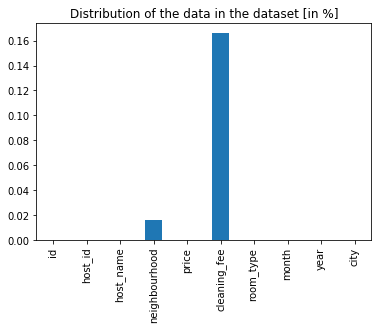

In [3]:
#CRISProcess | Data Understanding
#3. We need to understand where we have got N/A in the dataset

#Now we will vis. the missing values in the dataset for a better understanding
#Provide a pandas series of the counts for each missing value (relativ)
status_vals = df_Boston_all.isna().sum()
(status_vals/df_Boston_all.shape[0]).plot(kind="bar");
plt.title("Distribution of the data in the dataset [in %]");
#As we can see, round about 16% of the dataset has missing values for the cleaning_fee 
#and only 1% has missing values for theneighboorhoud

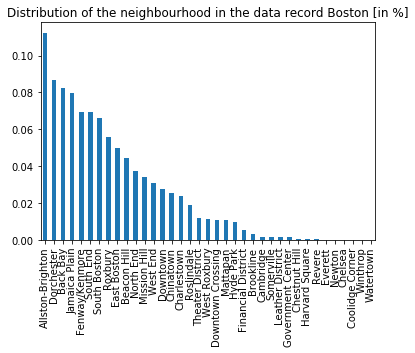

In [4]:
#CRISProcess | Data Understanding
#For answering questions on the prices of a room ect. First of all, we have to understand 
#whether the data is consistent and complete. For this purpose, we check the data on N / A 
#entries and evaluate them by showing the number of missing data in percent.
#Provide a pandas series of the counts for each neighbourhood status
ed_vals_Boston_all = pd.Series(df_Boston_all.neighbourhood.value_counts()) #counting the amount of neighbourhoods
(ed_vals_Boston_all/df_Boston_all.shape[0]).plot(kind="bar");
plt.title("Distribution of the neighbourhood in the data record Boston [in %]");
#As you can the Allston-Brighton was booked almost 12% of all other neighbourhoods

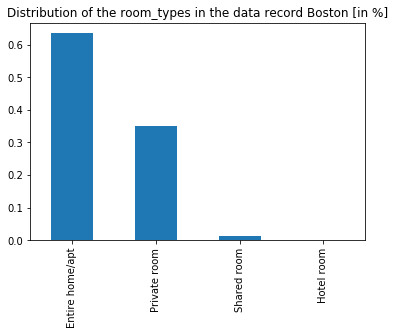

In [5]:
#CRISProcess | Data Understanding
#Now we would like to see which room_types are mostly frequentend
#Provide a pandas series of the counts for each room_type status
ed_vals_Boston_all = pd.Series(df_Boston_all.room_type.value_counts()) #counting the amount of room_types
(ed_vals_Boston_all/df_Boston_all.shape[0]).plot(kind="bar");
plt.title("Distribution of the room_types in the data record Boston [in %]");
#As you can Entrie home/apt and private rooms where booked the most

In [6]:
#CRISProcess | Data Understanding
#We could like to understand the price policy in Boston
#Therefore it is necessary to cast the columns with digits form object to float
df_Boston_all.dtypes;
#As we can see, the price and the cleaning fee are of the type object. Therefore we need a typecast for the next steps.
#Futhermore we have to get rid of the "$" sign in the column of price and cleaning_fee

In [7]:
#CRISProcess | Data Preparation 
#To check each column we will use use columns the get an array of columns which should be checked
colstocheck = df_Boston_all.columns
#To avoid cast problems because of signs like $ we replacing this by a blank
df_Boston_all[colstocheck] = df_Boston_all[colstocheck].replace({'\$':''}, regex = True)
#In the next step we casting the spec. columns from object to numerical
df_Boston_all['price'] = pd.to_numeric(df_Boston_all['price'], errors='coerce')
df_Boston_all['cleaning_fee'] = pd.to_numeric(df_Boston_all['cleaning_fee'], errors='coerce')
df_Boston_all.head();
#Now the have digits in the column price and cleaning_fee not objects

In [8]:
#CRISProcess | Data Preparation
#In the next steps we will start with our analysis and calculations
#therefore we get rid of each column or row with only N/A
df_Boston_all = df_Boston_all.dropna(axis=1, how='all');
df_Boston_all = df_Boston_all.dropna(axis=0, how='all');
df_Boston_all.head();

In [9]:
#CRISProcess | Data Preparation
#In the next step, we have got the problem, that the column moth is of the type object.
#Therefore we need do encode them by using the astype function and the cat.codes to assign each month a digit
#With this encoding we can use it for our machine learning modeling
df_Boston_all["month"] = df_Boston_all["month"].astype('category')
df_Boston_all["month_cat"] = df_Boston_all["month"].cat.codes
df_Boston_all.head()
#As you can see, we still got a problem. Dec is referenced to 2 but it should be 11. 
#So it means we have no order by date. Therefore we have to re-encode the month

,id,host_id,host_name,neighbourhood,price,cleaning_fee,room_type,month,year,city,month_cat
0,5506,8229,Terry,Roxbury,145.0,60.0,Entire home/apt,Dec,2019,Boston,2
1,6695,8229,Terry,Roxbury,169.0,80.0,Entire home/apt,Dec,2019,Boston,2
2,8789,26988,Anne,Beacon Hill,99.0,250.0,Entire home/apt,Dec,2019,Boston,2
3,10730,26988,Anne,Beacon Hill,150.0,250.0,Entire home/apt,Dec,2019,Boston,2
4,10811,38997,Michelle,Back Bay,84.0,150.0,Entire home/apt,Dec,2019,Boston,2


In [10]:
#CRISProcess | Data Preparation
#In the next step, we have got the problem, that the column month is of the type object.
#To identify which month are included in the dataset we will use unique to get each month_tag
df_Boston_all['month'].unique();
#You will see, that each month is included. We can´t use this array because we can not sort it in an order by date

In [11]:
#CRISProcess | Data Preparation
#We will use a array with shoutcuts which are included in the dataset:
month_tag_list = ['Jan', 'Feb', 'Mar', 'April', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
#And encode each month with a digit
month_number_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
#In the next step we will use a loop to replace each value in month with the matching number
i = 0; #counting variable to walk though the list of numbers in the loop
#In this loop we walk though the values in month and replacing each values with the maching number
for month_tag_list in month_tag_list:
    df_Boston_all['month'] = df_Boston_all['month'].replace({month_tag_list:month_number_list[i]}, regex = False)
    i = i+1; #counting the variable for the next number to replace
    
#In the end, each value in month should be a digit
month_tag_list = df_Boston_all['month'].unique()

In [12]:
#CRISProcess | Data Modeling
##########################################FIRST QUESTION####################################################################
#How does the current booking distribution of rooms in order to neighboorhoods in Boston 
#look like in 2019 and 2018?
#What is the mean price of the two most booked neighboorhoods by room_type in Boston in 2019 and 2018?
#By starting to answer this question we need will separed the date by year and room_type
#As we could see above, hotel rooms and shared rooms are booked under 1% and will be not encounted
#The next lines of code will get us a subsetdateframe
df_Boston_proom_2019 = df_Boston_all.loc[(df_Boston_all['room_type'] == 'Private room') & (df_Boston_all['year'] == 2019)] 
df_Boston_proom_2018 = df_Boston_all.loc[(df_Boston_all['room_type'] == 'Private room') & (df_Boston_all['year'] == 2018)]
df_Boston_entire_2019 = df_Boston_all.loc[(df_Boston_all['room_type'] == 'Entire home/apt') & (df_Boston_all['year'] == 2019)] 
df_Boston_entire_2018 = df_Boston_all.loc[(df_Boston_all['room_type'] == 'Entire home/apt') & (df_Boston_all['year'] == 2018)] 

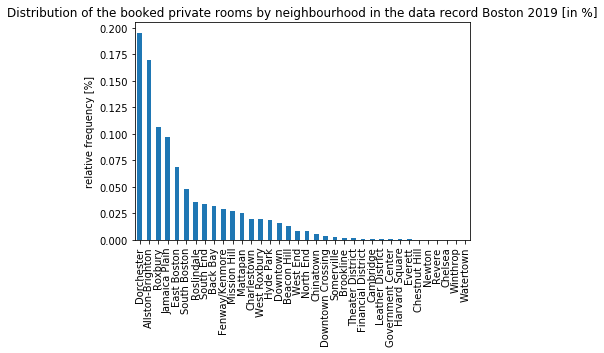

In [13]:
#How does the current booking distribution of rooms in order to neighboorhoods in Boston 
#look like in 2019?
#Provide a pandas series of the counts for each neighbourhood status
ed_vals_Boston_2019_proom = pd.Series(df_Boston_proom_2019.neighbourhood.value_counts())
(ed_vals_Boston_2019_proom/df_Boston_proom_2019.shape[0]).plot(kind="bar");
plt.title("Distribution of the booked private rooms by neighbourhood in the data record Boston 2019 [in %]");
ax = plt.gca();
ax.set_ylabel('relative frequency [%]');

In [14]:
#We would like to calculate the mean and median price of each neighbourhood for each year and room_type.
#Therefore we will build a dataframe with the following information
#Boston_<room_type>_<year>_values - is the dataset spec.
#Boston_proom_2019_max is the relative distribution of the booking in order of the total amount
#ed_vals_Boston_2019_proom is the absolut distribution of the booking in order of the total amount
#df_Boston_proom_2019.shape[0] is the total amount of the bookings in each neighbourhood
#result_mean_2019_proom is the mean price of a room in each neighbourhood
#result_median_2019_proom is the median price of a room in each neighbourhood
#We have got the following data: Private room 2019, Private room 2018, Entire Apt 2019, Entrie Apt 2018
#The following lines will used for each dataset

In [15]:
#Deviding the count of each neighbourhood by the total amount of booked rooms in 2019
Boston_proom_2019_max = ed_vals_Boston_2019_proom/df_Boston_proom_2019.shape[0]; #stores the booking distribution
#Storing the count of the booked neighbourhoods
neighbourhood_list_2019_proom = df_Boston_proom_2019.neighbourhood.value_counts().index.tolist()
result_mean_2019_proom = [] #variable to store the mean values
result_median_2019_proom = [] #variable to store the median values
#Evaluating the mean and median price of the roomtype private room in each neigbourhood in 2019
for neighbourhood_list_2019_proom in neighbourhood_list_2019_proom:
    df_tmp_prices = df_Boston_proom_2019.loc[df_Boston_proom_2019['neighbourhood'] == neighbourhood_list_2019_proom] #comparing the following neighbourhood name to apply the calculations
    result_mean_2019_proom.append(df_tmp_prices['price'].mean()) #calculating the mean price of all rooms in a neighbourhood
    result_median_2019_proom.append(df_tmp_prices['price'].median()) #calculating the median price of all rooms in a neighbourhood

In [16]:
#Boston_<room_type>_<year>_values is the new dataframe for storing the information above
df_Boston_2019_proom_values = pd.DataFrame([], columns = []) 
df_Boston_2019_proom_values.insert(0,'Boston_proom_2019_relativ',Boston_proom_2019_max)
df_Boston_2019_proom_values.insert(1,'Boston_proom_2019_absolut',ed_vals_Boston_2019_proom)
df_Boston_2019_proom_values.insert(2,'Boston_proom_2019_total_count',df_Boston_proom_2019.shape[0])
df_Boston_2019_proom_values.insert(3,'Boston_proom_2019_price_mean',result_mean_2019_proom)
df_Boston_2019_proom_values.insert(4,'Boston_proom_2019_price_median',result_median_2019_proom)

df_Boston_2019_proom_values.head();

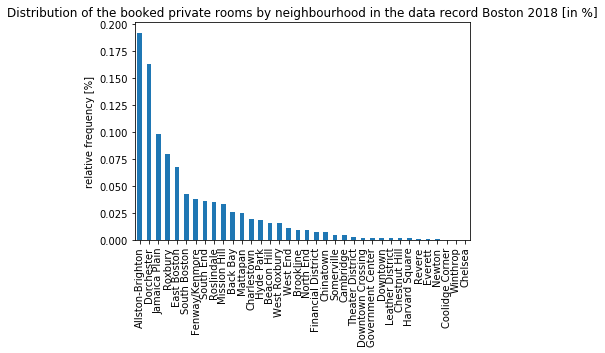

In [17]:
#How does the current booking distribution of rooms in order to neighboorhoods in Boston 
#look like in 2018?
#Provide a pandas series of the counts for each neighbourhood status
ed_vals_Boston_2018_proom = pd.Series(df_Boston_proom_2018.neighbourhood.value_counts())
(ed_vals_Boston_2018_proom/df_Boston_proom_2018.shape[0]).plot(kind="bar");
plt.title("Distribution of the booked private rooms by neighbourhood in the data record Boston 2018 [in %]");
Boston_proom_2018_max = ed_vals_Boston_2018_proom /df_Boston_proom_2018.shape[0];
ax = plt.gca();
ax.set_ylabel('relative frequency [%]');

In [18]:
#Deviding the count of each neighbourhood by the total amount of booked rooms in 2019
neighbourhood_list_2018_proom = df_Boston_proom_2018.neighbourhood.value_counts().index.tolist()
result_mean_2018_proom = [] #variable to store the mean values
result_median_2018_proom = [] #variable to store the median values
#Evaluating the mean and median price of the roomtype private room in each neigbourhood in 2018
for neighbourhood_list_2018_proom in neighbourhood_list_2018_proom:
    df_tmp_prices = df_Boston_proom_2018.loc[df_Boston_proom_2018['neighbourhood'] == neighbourhood_list_2018_proom] #comparing the following neighbourhood name to apply the calculations
    result_mean_2018_proom.append(df_tmp_prices['price'].mean()) #calculating the mean price of all rooms in a neighbourhood
    result_median_2018_proom.append(df_tmp_prices['price'].median()) #calculating the median price of all rooms in a neighbourhood

In [19]:
#Boston_<room_type>_<year>_values is the new dataframe for storing the information above
df_Boston_2018_proom_values = pd.DataFrame([], columns = []) 
df_Boston_2018_proom_values.insert(0,'Boston_proom_2018_relativ',Boston_proom_2018_max)
df_Boston_2018_proom_values.insert(1,'Boston_proom_2018_absolut',ed_vals_Boston_2018_proom)
df_Boston_2018_proom_values.insert(2,'Boston_proom_2018_total_count',df_Boston_proom_2018.shape[0])
df_Boston_2018_proom_values.insert(3,'Boston_proom_2018_price_mean',result_mean_2018_proom)
df_Boston_2018_proom_values.insert(4,'Boston_proom_2018_price_median',result_median_2018_proom)

df_Boston_2018_proom_values.head();

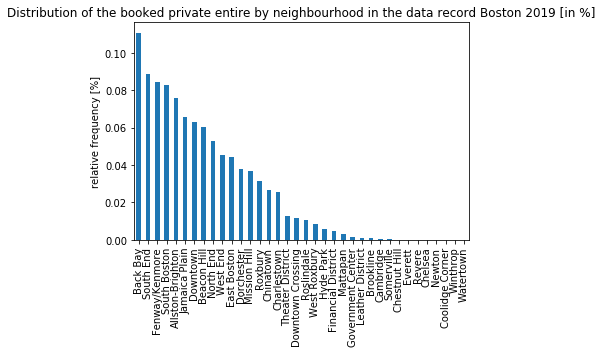

In [20]:
#How does the current booking distribution of rooms in order to neighboorhoods in Boston 
#look like in 2019?
#Provide a pandas series of the counts for each neighbourhood status
ed_vals_Boston_2019_entire = pd.Series(df_Boston_entire_2019.neighbourhood.value_counts())
(ed_vals_Boston_2019_entire/df_Boston_entire_2019.shape[0]).plot(kind="bar");
plt.title("Distribution of the booked private entire by neighbourhood in the data record Boston 2019 [in %]");
Boston_entire_2019_max = ed_vals_Boston_2019_entire/df_Boston_entire_2019.shape[0];
ax = plt.gca();
ax.set_ylabel('relative frequency [%]');

In [21]:
#Deviding the count of each neighbourhood by the total amount of booked rooms in 2019
neighbourhood_list_2019_entire = df_Boston_entire_2019.neighbourhood.value_counts().index.tolist()
result_mean_2019_entire = []
result_median_2019_entire = []

#Evaluating the mean and median price of the roomtype entire apt in each neigbourhood in 2019
for neighbourhood_list_2019_entire in neighbourhood_list_2019_entire:
    df_tmp_prices = df_Boston_entire_2019.loc[df_Boston_entire_2019['neighbourhood'] == neighbourhood_list_2019_entire] #comparing the following neighbourhood name to apply the calculations
    result_mean_2019_entire.append(df_tmp_prices['price'].mean()) #calculating the mean price of all rooms in a neighbourhood
    result_median_2019_entire.append(df_tmp_prices['price'].median()) #calculating the median price of all rooms in a neighbourhood
    
#Boston_<room_type>_<year>_values is the new dataframe for storing the information above
df_Boston_2019_entire_values = pd.DataFrame([], columns = []) 
df_Boston_2019_entire_values.insert(0,'Boston_entire_2019_relativ',Boston_entire_2019_max)
df_Boston_2019_entire_values.insert(1,'Boston_entire_2019_absolut',ed_vals_Boston_2019_entire)
df_Boston_2019_entire_values.insert(2,'Boston_entire_2019_total_count',df_Boston_entire_2019.shape[0])
df_Boston_2019_entire_values.insert(3,'Boston_entire_2019_price_mean',result_mean_2019_entire)
df_Boston_2019_entire_values.insert(3,'Boston_entire_2019_price_median',result_median_2019_entire)

df_Boston_2019_entire_values.head();

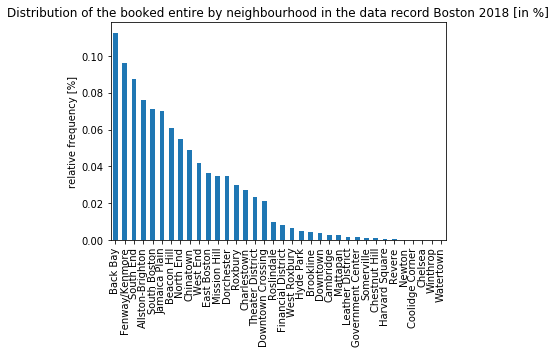

In [22]:
#How does the current booking distribution of rooms in order to neighboorhoods in Boston 
#look like in 2018?
#Provide a pandas series of the counts for each neighbourhood status
ed_vals_Boston_2018_entire = pd.Series(df_Boston_entire_2018.neighbourhood.value_counts())
(ed_vals_Boston_2018_entire/df_Boston_entire_2018.shape[0]).plot(kind="bar");
plt.title("Distribution of the booked entire by neighbourhood in the data record Boston 2018 [in %]");
Boston_entire_2018_max = ed_vals_Boston_2018_entire/df_Boston_entire_2018.shape[0];
ax = plt.gca();
ax.set_ylabel('relative frequency [%]');

In [23]:
#Deviding the count of each neighbourhood by the total amount of booked rooms in 2018
neighbourhood_list_2018_entire = df_Boston_entire_2018.neighbourhood.value_counts().index.tolist()
result_mean_2018_entire = []
result_median_2018_entire = []
#Evaluating the mean and median price of the roomtype entire apt in each neigbourhood in 2018
for neighbourhood_list_2018_entire in neighbourhood_list_2018_entire:
    df_tmp_prices = df_Boston_entire_2018.loc[df_Boston_entire_2018['neighbourhood'] == neighbourhood_list_2018_entire]
    result_mean_2018_entire.append(df_tmp_prices['price'].mean()) #calculating the mean price of all rooms in a neighbourhood
    result_median_2018_entire.append(df_tmp_prices['price'].median()) #calculating the median price of all rooms in a neighbourhood

In [24]:
#Boston_<room_type>_<year>_values is the new dataframe for storing the information above
df_Boston_2018_entire_values = pd.DataFrame([], columns = []) 
df_Boston_2018_entire_values.insert(0,'Boston_entire_2018_relativ',Boston_entire_2018_max)
df_Boston_2018_entire_values.insert(1,'Boston_entire_2018_absolut',ed_vals_Boston_2018_entire)
df_Boston_2018_entire_values.insert(2,'Boston_entire_2018_total_count',df_Boston_entire_2018.shape[0])
df_Boston_2018_entire_values.insert(3,'Boston_entire_2018_price_mean',result_mean_2018_entire)
df_Boston_2018_entire_values.insert(4,'Boston_entire_2018_price_median',result_median_2018_entire)

df_Boston_2018_entire_values.head();

In [25]:
#We want to combine the individual dataframes for evaluation so we will merge the above dataframes in a single one
df_Boston_roomtype_max = pd.DataFrame([], columns = []) 
df_Boston_roomtype_max.insert(0,'Boston_proom_2019_absolut',df_Boston_2019_proom_values['Boston_proom_2019_absolut'])
df_Boston_roomtype_max.insert(1,'Boston_proom_2019_mean',df_Boston_2019_proom_values['Boston_proom_2019_price_mean'])
df_Boston_roomtype_max.insert(2,'Boston_proom_2019_median',df_Boston_2019_proom_values['Boston_proom_2019_price_median'])

df_Boston_roomtype_max.insert(3,'Boston_proom_2018_absolut',df_Boston_2018_proom_values['Boston_proom_2018_absolut'])
df_Boston_roomtype_max.insert(4,'Boston_proom_2018_mean',df_Boston_2018_proom_values['Boston_proom_2018_price_mean'])
df_Boston_roomtype_max.insert(5,'Boston_proom_2018_median',df_Boston_2018_proom_values['Boston_proom_2018_price_median'])

df_Boston_roomtype_max.insert(6,'Boston_entire_2019_absolut',df_Boston_2019_entire_values['Boston_entire_2019_absolut'])
df_Boston_roomtype_max.insert(7,'Boston_entire_2019_mean',df_Boston_2019_entire_values['Boston_entire_2019_price_mean'])
df_Boston_roomtype_max.insert(8,'Boston_entire_2019_median',df_Boston_2019_entire_values['Boston_entire_2019_price_median'])

df_Boston_roomtype_max.insert(9,'Boston_entire_2018_absolut',df_Boston_2018_entire_values['Boston_entire_2018_absolut'])
df_Boston_roomtype_max.insert(10,'Boston_entire_2018_mean',df_Boston_2018_entire_values['Boston_entire_2018_price_mean'])
df_Boston_roomtype_max.insert(11,'Boston_entire_2018_median',df_Boston_2018_entire_values['Boston_entire_2018_price_median'])

df_Boston_roomtype_max.head()

,Boston_proom_2019_absolut,Boston_proom_2019_mean,Boston_proom_2019_median,Boston_proom_2018_absolut,Boston_proom_2018_mean,Boston_proom_2018_median,Boston_entire_2019_absolut,Boston_entire_2019_mean,Boston_entire_2019_median,Boston_entire_2018_absolut,Boston_entire_2018_mean,Boston_entire_2018_median
Dorchester,5036,71.668588,62.0,2766.0,71.421186,64.0,1764.0,185.484954,149.0,1082.0,164.721649,150.0
Allston-Brighton,4365,71.791370,60.0,3265.0,68.729862,60.0,3541.0,178.935354,149.0,2376.0,176.600522,143.0
Roxbury,2758,66.779550,60.0,1352.0,68.957840,66.0,1477.0,216.688652,167.0,931.0,200.603732,160.0
Jamaica Plain,2495,82.728187,75.0,1667.0,77.395921,72.0,3064.0,201.184453,173.0,2190.0,199.580365,174.0
East Boston,1775,75.424225,69.0,1151.0,70.198089,65.0,2073.0,173.332369,167.0,1139.0,175.494293,150.0


In [26]:
#What is the mean price of the two most booked neighboorhoods in Boston in 2019?
#Sorting the values by their prices
Boston_proom_2019_mean_values_sorted = df_Boston_roomtype_max['Boston_proom_2018_mean'].sort_values(ascending=False)
#Getting the rows of the sorted values to display the first ones
Boston_proom_2019_mean_name_sorted = Boston_proom_2019_mean_values_sorted.axes[0].tolist()

print('The mean price of the most booked private room in 2019 is: ', str(Boston_proom_2019_mean_values_sorted[0]), 'in ', str(Boston_proom_2019_mean_name_sorted[0]))
print('The mean price of the second most booked private room in 2019 is: ', str(Boston_proom_2019_mean_values_sorted[1]), 'in ', str(Boston_proom_2019_mean_name_sorted[1]))

#Sorting the values by their prices
Boston_proom_2018_mean_values_sorted = df_Boston_roomtype_max['Boston_proom_2018_mean'].sort_values(ascending=False)
#Getting the rows of the sorted values to display the first ones
Boston_proom_2018_mean_name_sorted = Boston_proom_2018_mean_values_sorted.axes[0].tolist()

print('The mean price of the most booked private room in 2018 is: ', str(Boston_proom_2018_mean_values_sorted[0]), 'in ', str(Boston_proom_2018_mean_name_sorted[0]))
print('The mean price of the second most booked private room in 2018 is: ', str(Boston_proom_2018_mean_values_sorted[1]), 'in ', str(Boston_proom_2018_mean_name_sorted[1]))

#Sorting the values by their prices
Boston_entire_2019_mean_values_sorted = df_Boston_roomtype_max['Boston_entire_2019_mean'].sort_values(ascending=False)
#Getting the rows of the sorted values to display the first ones
Boston_entire_2019_mean_name_sorted = Boston_entire_2019_mean_values_sorted.axes[0].tolist()

print('The mean price of the most booked entire apt. in 2019 is: ', str(Boston_entire_2019_mean_values_sorted[0]),'in ',str(Boston_entire_2019_mean_name_sorted[0]))
print('The mean price of the second most booked entire apt. in 2019 is: ', str(Boston_entire_2019_mean_values_sorted[1]), 'in ', str(Boston_entire_2019_mean_name_sorted[1]))

#Sorting the values by their prices
Boston_entire_2018_mean_values_sorted = df_Boston_roomtype_max['Boston_entire_2018_mean'].sort_values(ascending=False)
#Getting the rows of the sorted values to display the first ones
Boston_entire_2018_mean_name_sorted = Boston_entire_2018_mean_values_sorted.axes[0].tolist()

print('The mean price of the most booked entire apt. in 2018 is: ', str(Boston_entire_2018_mean_values_sorted[0]),'in ', str(Boston_entire_2018_mean_name_sorted[0]))
print('The mean price of the second most booked entire apt. in 2018 is: ', str(Boston_entire_2018_mean_values_sorted[1]), 'in ', str(Boston_entire_2018_mean_name_sorted[1]))

The mean price of the most booked private room in 2019 is:  263.91269841269843 in  Financial District
The mean price of the second most booked private room in 2019 is:  210.2 in  Downtown Crossing
The mean price of the most booked private room in 2018 is:  263.91269841269843 in  Financial District
The mean price of the second most booked private room in 2018 is:  210.2 in  Downtown Crossing
The mean price of the most booked entire apt. in 2019 is:  441.06976744186045 in  Leather District
The mean price of the second most booked entire apt. in 2019 is:  381.6164383561644 in  Government Center
The mean price of the most booked entire apt. in 2018 is:  363.3863636363636 in  Government Center
The mean price of the second most booked entire apt. in 2018 is:  344.62745098039215 in  Leather District


In [27]:
##########################################Second business question####################################################################
#The second business question: How did the average price for the individual room types 
#develop from 2018 to 2019? The market potential can be derived here.

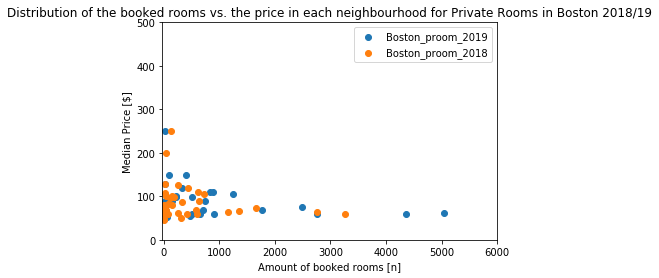

In [28]:
#For answering the next question we need to understand the data behaviour and the price distribution
#We will show the mean and median values of the two roomtypes in 2018/19. Next we will calculate the differences
#and trying to understand the market potential and situation. For getting a better understanding we will estimate the
#mean and die median of the values to avoid a biased view on the data because of outliners.
#First we will plot the mean prices vs. the amount of booked rooms
plt.scatter(df_Boston_2019_proom_values['Boston_proom_2019_absolut'], df_Boston_2019_proom_values['Boston_proom_2019_price_median'],label='Boston_proom_2019')
plt.scatter(df_Boston_2018_proom_values['Boston_proom_2018_absolut'], df_Boston_2018_proom_values['Boston_proom_2018_price_median'],label='Boston_proom_2018')
ax = plt.gca()
plt.legend()
ax.set_ylim([0,500])
ax.set_xlim([-25,6000])
plt.title("Distribution of the booked rooms vs. the price in each neighbourhood for Private Rooms in Boston 2018/19");
ax.set_xlabel('Amount of booked rooms [n]');
ax.set_ylabel('Median Price [$]');
plt.show()
#As we can see, the median price of a private room in Boston in 2018 and 2019 is similar

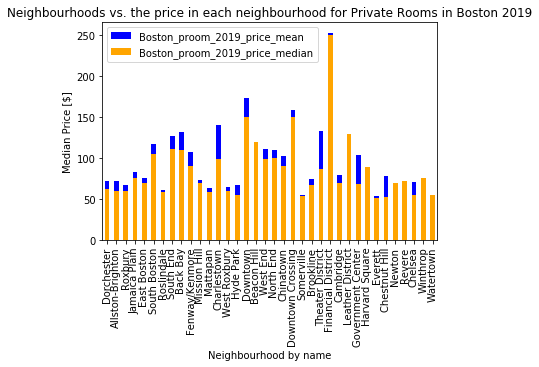

In [29]:
#In the next plot we will show the difference between the mean price and the median price
#We would like to understand the difference for the modeling in the next steps
#The modeling question is, which one of this two values should used for a model to estimat and predict the price
(df_Boston_2019_proom_values['Boston_proom_2019_price_mean']).plot(kind="bar",color='blue');
(df_Boston_2019_proom_values['Boston_proom_2019_price_median']).plot(kind="bar",color='orange');
ax = plt.gca()
plt.legend()
plt.title("Neighbourhoods vs. the price in each neighbourhood for Private Rooms in Boston 2019");
ax.set_xlabel('Neighbourhood by name');
ax.set_ylabel('Median Price [$]');
plt.show()
#We can see, the greatest difference appears for the Theater District and Charlestown

In [30]:
#By using the describe function we will see the mean value of the mean prices and the median price of the prices
df_Boston_2019_proom_values.describe();

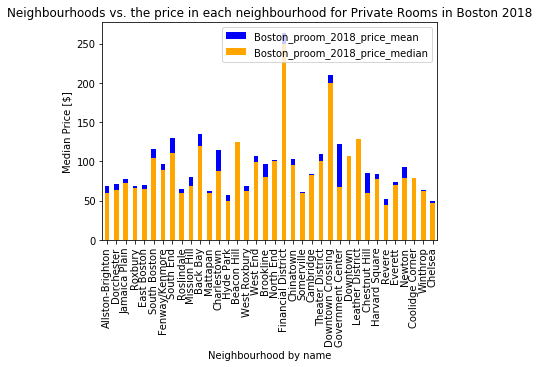

In [31]:
#In the next plot we will show the difference between the mean price and the median price
#We would like to understand the difference for the modeling in the next steps
#The modeling question is, which one of this two values should used for a model to estimat and predict the price
(df_Boston_2018_proom_values['Boston_proom_2018_price_mean']).plot(kind="bar",color='blue');
(df_Boston_2018_proom_values['Boston_proom_2018_price_median']).plot(kind="bar",color='orange');
ax = plt.gca()
plt.legend()
plt.title("Neighbourhoods vs. the price in each neighbourhood for Private Rooms in Boston 2018");
ax.set_xlabel('Neighbourhood by name');
ax.set_ylabel('Median Price [$]');
plt.show()
#We can see, the greatest difference appears for the Government Center and Charlestown

In [32]:
#By using the describe function we will see the mean value of the mean prices and the median price of the prices
df_Boston_2018_proom_values.describe();

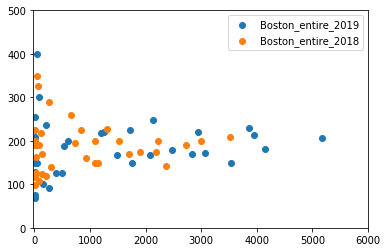

In [33]:
#For getting a better understanding we will estimate the
#mean and die median of the values to avoid a biased view on the data because of outliners.
#First we will plot the mean prices vs. the amount of booked rooms
plt.scatter(df_Boston_2019_entire_values['Boston_entire_2019_absolut'], df_Boston_2019_entire_values['Boston_entire_2019_price_median'],label='Boston_entire_2019')
plt.scatter(df_Boston_2018_entire_values['Boston_entire_2018_absolut'], df_Boston_2018_entire_values['Boston_entire_2018_price_median'],label='Boston_entire_2018')
ax = plt.gca()
plt.legend()
ax.set_ylim([0,500])
ax.set_xlim([-25,6000])
plt.show()
#As we can see, the median price of a entire apt. in Boston in 2018 and 2019 is similar. It looks like that the price
#is slightly growing

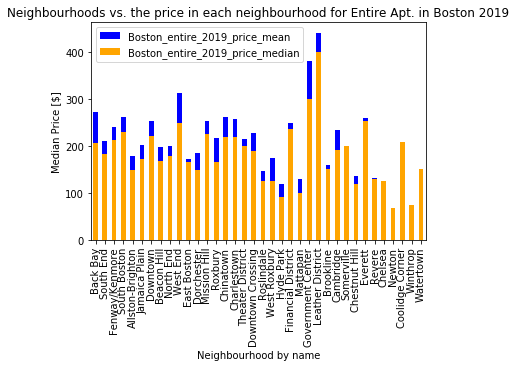

In [34]:
#In the next plot we will show the difference between the mean price and the median price
#We would like to understand the difference for the modeling in the next steps
#The modeling question is, which one of this two values should used for a model to estimat and predict the price
(df_Boston_2019_entire_values['Boston_entire_2019_price_mean']).plot(kind="bar",color='blue');
(df_Boston_2019_entire_values['Boston_entire_2019_price_median']).plot(kind="bar",color='orange');
ax = plt.gca()
plt.legend()
plt.title("Neighbourhoods vs. the price in each neighbourhood for Entire Apt. in Boston 2019");
ax.set_xlabel('Neighbourhood by name');
ax.set_ylabel('Median Price [$]');
plt.show()
#We can see, the greatest difference appears for the Government Center and West End

In [35]:
#By using the describe function we will see the mean value of the mean prices and the median price of the prices
df_Boston_2019_entire_values.describe()

,Boston_entire_2019_relativ,Boston_entire_2019_absolut,Boston_entire_2019_total_count,Boston_entire_2019_price_median,Boston_entire_2019_price_mean
count,36.000000,36.000000,36.0,36.000000,36.000000
mean,0.027621,1290.888889,46736.0,182.027778,208.418081
std,0.032424,1515.387980,0.0,64.608817,75.840062
min,0.000021,1.000000,46736.0,68.000000,68.000000
25%,0.000417,19.500000,46736.0,144.000000,157.723404
50%,0.010977,513.000000,46736.0,180.250000,204.592227
75%,0.047394,2215.000000,46736.0,219.250000,253.329871
max,0.110664,5172.000000,46736.0,400.000000,441.069767


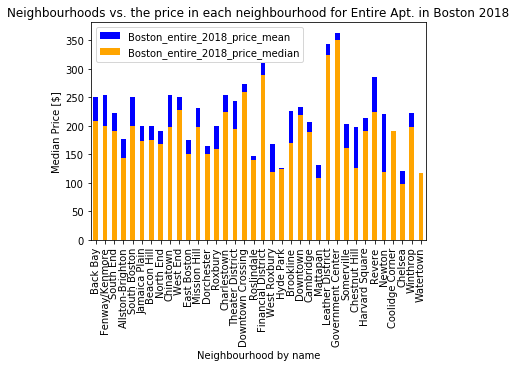

In [36]:
#In the next plot we will show the difference between the mean price and the median price
#We would like to understand the difference for the modeling in the next steps
#The modeling question is, which one of this two values should used for a model to estimat and predict the price
(df_Boston_2018_entire_values['Boston_entire_2018_price_mean']).plot(kind="bar",color='blue');
(df_Boston_2018_entire_values['Boston_entire_2018_price_median']).plot(kind="bar",color='orange');
ax = plt.gca()
plt.legend()
plt.title("Neighbourhoods vs. the price in each neighbourhood for Entire Apt. in Boston 2018");
ax.set_xlabel('Neighbourhood by name');
ax.set_ylabel('Median Price [$]');
plt.show()
#We can see, the greatest difference appears for the Revere and Newtown

In [37]:
#By using the describe function we will see the mean value of the mean prices and the median price of the prices
df_Boston_2018_entire_values.describe()

,Boston_entire_2018_relativ,Boston_entire_2018_absolut,Boston_entire_2018_total_count,Boston_entire_2018_price_mean,Boston_entire_2018_price_median
count,36.000000,36.000000,36.0,36.000000,36.000000
mean,0.027121,846.000000,31194.0,217.113063,185.902778
std,0.032244,1005.828188,0.0,57.328978,56.750559
min,0.000064,2.000000,31194.0,117.000000,99.000000
25%,0.001298,40.500000,31194.0,180.200131,148.250000
50%,0.008880,277.000000,31194.0,217.257937,190.500000
75%,0.043518,1357.500000,31194.0,250.620394,202.250000
max,0.112554,3511.000000,31194.0,363.386364,350.000000


In [38]:
df_Boston_roomtype_max.head(40);

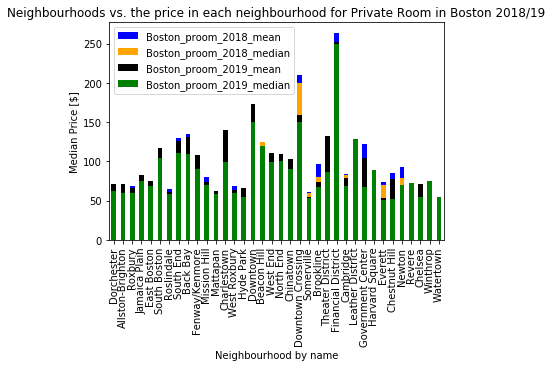

In [39]:
#In the next plot we will show the difference between the mean price and the median price
#We would like to understand the difference for the modeling in the next steps
#The modeling question is, which of the following values should be used to estimate a new price in 2020
#In the next plot, we show all values to compare them
(df_Boston_roomtype_max['Boston_proom_2018_mean']).plot(kind="bar",color='blue');
(df_Boston_roomtype_max['Boston_proom_2018_median']).plot(kind="bar",color='orange');
(df_Boston_roomtype_max['Boston_proom_2019_mean']).plot(kind="bar",color='black');
(df_Boston_roomtype_max['Boston_proom_2019_median']).plot(kind="bar",color='green');
ax = plt.gca()
plt.legend()
plt.title("Neighbourhoods vs. the price in each neighbourhood for Private Room in Boston 2018/19");
ax.set_xlabel('Neighbourhood by name');
ax.set_ylabel('Median Price [$]');
plt.show()
#The plot shows that the price for a private room in Boston rises a little bit from 2018 to 2019
#The mean value seems to be a good choice to use for a worst case estimation because it is slightly higher
#then the median value.

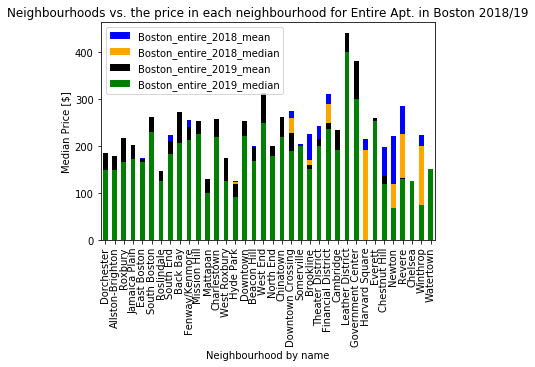

In [40]:
#In the next plot we will show the difference between the mean price and the median price
#We would like to understand the difference for the modeling in the next steps
#The modeling question is, which of the following values should be used to estimate a new price in 2020
#In the next plot, we show all values to compare them
(df_Boston_roomtype_max['Boston_entire_2018_mean']).plot(kind="bar",color='blue');
(df_Boston_roomtype_max['Boston_entire_2018_median']).plot(kind="bar",color='orange');
(df_Boston_roomtype_max['Boston_entire_2019_mean']).plot(kind="bar",color='black');
(df_Boston_roomtype_max['Boston_entire_2019_median']).plot(kind="bar",color='green');
ax = plt.gca()
plt.legend()
plt.title("Neighbourhoods vs. the price in each neighbourhood for Entire Apt. in Boston 2018/19");
ax.set_xlabel('Neighbourhood by name');
ax.set_ylabel('Median Price [$]');
plt.show()
#The plot shows that the price for a entire apt. in Boston rises from 2018 to 2019
#The mean value seems to be a good choice to use for a worst case estimation because it is higher
#then the median value.

In [41]:
df_Boston_roomtype_max.head()

,Boston_proom_2019_absolut,Boston_proom_2019_mean,Boston_proom_2019_median,Boston_proom_2018_absolut,Boston_proom_2018_mean,Boston_proom_2018_median,Boston_entire_2019_absolut,Boston_entire_2019_mean,Boston_entire_2019_median,Boston_entire_2018_absolut,Boston_entire_2018_mean,Boston_entire_2018_median
Dorchester,5036,71.668588,62.0,2766.0,71.421186,64.0,1764.0,185.484954,149.0,1082.0,164.721649,150.0
Allston-Brighton,4365,71.791370,60.0,3265.0,68.729862,60.0,3541.0,178.935354,149.0,2376.0,176.600522,143.0
Roxbury,2758,66.779550,60.0,1352.0,68.957840,66.0,1477.0,216.688652,167.0,931.0,200.603732,160.0
Jamaica Plain,2495,82.728187,75.0,1667.0,77.395921,72.0,3064.0,201.184453,173.0,2190.0,199.580365,174.0
East Boston,1775,75.424225,69.0,1151.0,70.198089,65.0,2073.0,173.332369,167.0,1139.0,175.494293,150.0


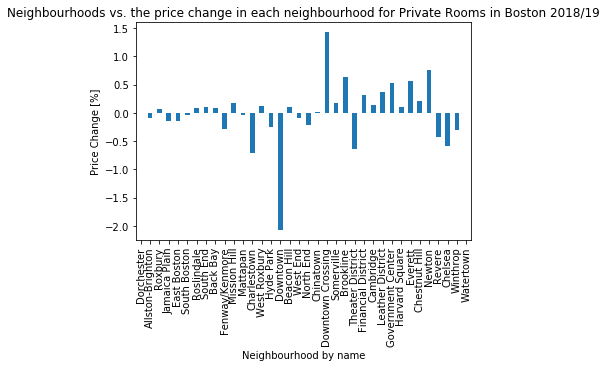

In [42]:
#In the next plot we will show the difference of the price mean value in %. So we see the price behaviour 
#for each neighbourhood:
Boston_proom_2019_mean_value = df_Boston_roomtype_max['Boston_proom_2019_mean'];
Boston_proom_2018_mean_value = df_Boston_roomtype_max['Boston_proom_2018_mean'];
((Boston_proom_2018_mean_value-Boston_proom_2019_mean_value)/df_Boston_roomtype_max.shape[0]).plot(kind="bar");
ax = plt.gca()
plt.title("Neighbourhoods vs. the price change in each neighbourhood for Private Rooms in Boston 2018/19");
ax.set_xlabel('Neighbourhood by name');
ax.set_ylabel('Price Change [%]');
plt.show()
#As we can see, the price rises in Downtown Crossing round about 1.4% and falls round about -2.0% in Downtown

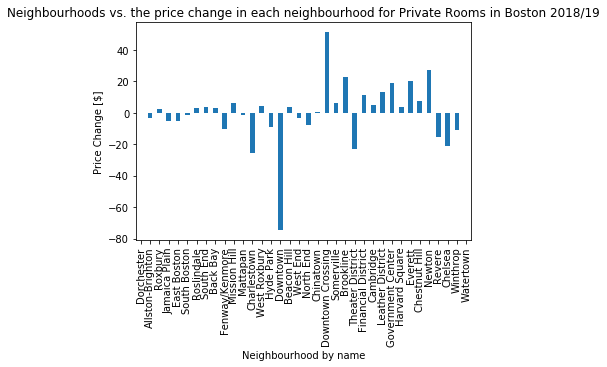

In [43]:
#In the next plot we will show the difference of the price mean value in %. So we see the price behaviour 
#for each neighbourhood:
Boston_proom_2019_mean_value = df_Boston_roomtype_max['Boston_proom_2019_mean'];
Boston_proom_2018_mean_value = df_Boston_roomtype_max['Boston_proom_2018_mean'];
((Boston_proom_2018_mean_value-Boston_proom_2019_mean_value)).plot(kind="bar");
ax = plt.gca()
plt.title("Neighbourhoods vs. the price change in each neighbourhood for Private Rooms in Boston 2018/19");
ax.set_xlabel('Neighbourhood by name');
ax.set_ylabel('Price Change [$]');
plt.show()
#As we can see, the price rises in Downtown Crossing round about 50$ and falls round about -70% in Downtown

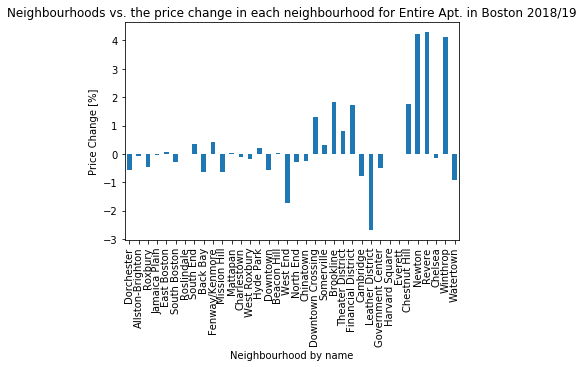

In [44]:
#In the next plot we will show the difference of the price mean value in %. So we see the price behaviour 
#for each neighbourhood:
Boston_entire_2019_mean_value = df_Boston_roomtype_max['Boston_entire_2019_mean'];
Boston_entire_2018_mean_value = df_Boston_roomtype_max['Boston_entire_2018_mean'];
((Boston_entire_2018_mean_value-Boston_entire_2019_mean_value)/df_Boston_roomtype_max.shape[0]).plot(kind="bar");
ax = plt.gca()
plt.title("Neighbourhoods vs. the price change in each neighbourhood for Entire Apt. in Boston 2018/19");
ax.set_xlabel('Neighbourhood by name');
ax.set_ylabel('Price Change [%]');
plt.show()
#As we can see, the price rises in Revere, Newtown and Winthrop round about 4% and is falling round about -2.5% in the Leather District
#In this case, it seems to be that the markt potential is higher for entire apts. as for private room because of the
#rising prices

In [45]:
#Here, marketing measures can be derived in the corresponding districts where the price is falling. 
#And it analyzes why the price is rising in some parts of the city in order to be able to place targeted advertisements.

In [46]:
#The third business question:
#Is it possible to derive the price from the previous data based on the room type and location? 
#The customer behavior and the market situation can be derived from this.
#Is it possible to predict the price development for all room types 
#using a linear model depending on the room type and neighborhood?
#Questions of a marketing department could be: In which district 
#should we advertise more or what types of rooms should we also market social platforms more?

#For this approach we will create a dataframe which will consider the mean price of each roomtype in behalf of 
#the month in 2018/19. By using this timeseries we will estimate a linear model to predict the price trend for 2020

#CRISProcess | Data Modeling
##########################################THIRD QUESTION####################################################################
#We will start with two functions. This functions will extract the data from the current dataframe and preprocessing them
#for a linear model. After this step we will follow the CRISProcess for modeling the data by splitting the data in test
#and training data. Training the model and evaluating it. Predicting the prices and optimizing the model for a conclusion:

#    Summary
#    1. Drop the rows with missing response values
#    2. Drop columns with NaN for all the values
#    3. Use create_dummy_df to dummy categorical columns
#    4. Fill the mean of the column for any missing values 
#    5. Split your data into an X matrix and a response vector y
#    6. Create training and test sets of data
#    7. Instantiate a LinearRegression model with normalized data
#    8. Fit your model to the training data
#    9. Predict the response for the training data and the test data
#    10. Obtain an rsquared value for both the training and test data

In [47]:
def neighbourhood_stats(df_values,neighbourhood_array,value):
    
    '''
    INPUT:
    df_values - a dataframe holding all the variables of interest
    neighbourhood_array - an array with the names of the neighbourhoods
    value - is the month in which the approach should be done
    
    OUTPUT:
    df_neighbourhood_stats - a dateframe with the following stats
    neighbourhood_name - the name of the neighbourhoods
    max - the max value in a month spec. by input value month
    min - the min value in a month spec. by input value month
    mean - the mean value in a month spec. by input value month
    month - the month value in a month spec. by input value month
    median- the median value in a month spec. by input value month
    
    DESCRIBTION:
    1. Init of the temp variables
    2. Calculating the stats for each month through every neighbourhood
    '''
    
    # Creating new dataframe for storing the calculated values
    df_neighbourhood_stats = pd.DataFrame([], columns = ['neighbourhood_name', 'max', 'min', 'mean', 'month','median']) 
    # Create lists for temporary storage
    result_neight = []
    result_max = []
    result_min = []
    result_mean = []
    result_median = []
    result_month = []
    
    # In this loop, a list of neighborhoods is run through and the mean, max, min values and 
    # median of each neighborhood are calculated and temporarily stored in a list
    for neighbourhood_array in neighbourhood_array:
        df_tmp_prices = df_values.loc[df_values['neighbourhood'] == neighbourhood_array] #creating a tmp dateframe for each neighbourhood
        result_neight.append(neighbourhood_array) #appending the name of the neighbourhood
        result_max.append(df_tmp_prices['price'].max())
        result_min.append(df_tmp_prices['price'].min())
        result_mean.append(df_tmp_prices['price'].mean())
        result_median.append(df_tmp_prices['price'].median())
        result_month.append(value) #appending the month
    
    # Storing every list in a dateframe
    df_neighbourhood_stats['neighbourhood_name'] = result_neight;
    df_neighbourhood_stats['max'] = result_max;
    df_neighbourhood_stats['min'] = result_min;
    df_neighbourhood_stats['mean'] = result_mean;
    df_neighbourhood_stats['median'] = result_median;
    df_neighbourhood_stats['month'] = result_month;
    
    return df_neighbourhood_stats

In [48]:
def month_stats(df_Boston_x):
    
    '''
    INPUT:
    df_Boston_x - a dataframe for a spec. roomtype
    
    OUTPUT:
    df_month_stats - a dateframe with the following stats for each month
    
    DESCRIBTION:
    1. Init of the temp variables
    2. Calculating the stats for each month through every neighbourhood
    '''
    
    # Creating a list of each unique neighbourhood name to run through
    neighbourhood_array = df_Boston_x['neighbourhood'].unique();
    
    # Creating a list of each unique month name to run through
    month_array = df_Boston_x['month'].unique()
    
    # Creating a list of each unique month categorie name to run through
    month_array_cat = df_Boston_x['month_cat'].unique()
    
    # Creating a list of each unique month to iterate it
    month_array_index = df_Boston_x['month'].unique()
    
    # Create lists for temporary storage
    result_max_month = []
    result_min_month = []
    result_mean_month = []
    result_month_month = []
    result_month_month_cat = []
    result_median_month = []
    all_data = []

    # Index variable to iterate the months
    i = 0;
    
    # Creating new dataframe for storing the calculated values 
    df_month_stats = pd.DataFrame(all_data, columns = ['month','month_cat', 'max', 'min', 'mean', 'median'])   

    # In this loop, a list of months is run through and the mean, max, min values and 
    # median of each neighborhood and month are calculated and temporarily stored in a list
    for month_array in month_array:

        df_tmp = df_Boston_x.loc[df_Boston_x['month'] == month_array]; #creating a tmp dateframe for each month
        value = month_array_index[i]; #getting the month on a spec. index to write it in the output dataframe
        value_cat = month_array_cat[i]; #getting the month cat on a spec. index to write it in the output dataframe
        #using the neighbourhood_stats function for calc the states of each neighbourhood appearing in this month
        df_tmp = neighbourhood_stats(df_tmp,neighbourhood_array,value); 
        #increasing the index variable
        i = i+1;
        #appending the data
        result_max_month.append(df_tmp['max'].max())
        result_min_month.append(df_tmp['min'].min())
        result_mean_month.append(df_tmp['mean'].mean())
        result_median_month.append(df_tmp['mean'].median())
        result_month_month.append(value) #appending the month
        result_month_month_cat.append(value_cat) #appending the month categorie
    
    # Storing every list in a dateframe
    df_month_stats['month_cat'] = result_month_month_cat;
    df_month_stats['month'] = result_month_month;
    df_month_stats['max'] = result_max_month;
    df_month_stats['min'] = result_min_month;
    df_month_stats['mean'] = result_mean_month;
    df_month_stats['median'] = result_median_month;
    
    return df_month_stats

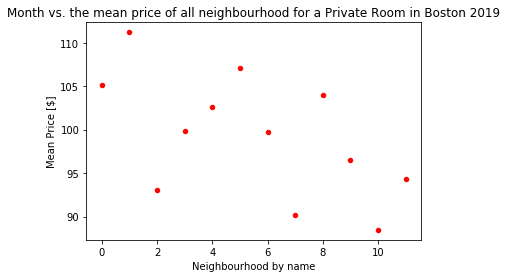

,month,month_cat,max,min,mean,median
4,1,4,900.0,0.0,102.620907,86.888889
3,2,3,900.0,0.0,99.848418,86.888889
7,3,7,900.0,0.0,90.196332,72.598214
1,4,0,762.0,0.0,105.191657,98.545455
8,5,8,762.0,0.0,103.931602,84.042654
6,6,6,680.0,0.0,99.707757,98.000000
5,7,5,500.0,0.0,107.075967,80.881517
2,8,1,500.0,0.0,111.198371,95.250000
11,9,11,850.0,0.0,94.375201,82.899390
10,10,10,850.0,0.0,88.474784,75.000000


In [49]:
#CRISProcess | Data Modeling
#By using the functions above we will show the mean prices of a spec. room type for each year
#to understand how the model should look like (with kind of model with should use)

#Using the month_stats function on the dataframe of private rooms in Boston in 2019
df_2019_month_proom = month_stats(df_Boston_proom_2019);

#Plotting the prices of each month of private rooms in Boston in 2019
df_2019_month_proom.plot(kind='scatter',x='month_cat',y='mean',color='red')
ax = plt.gca()
plt.title("Month vs. the mean price of all neighbourhood for a Private Room in Boston 2019");
ax.set_xlabel('Neighbourhood by name');
ax.set_ylabel('Mean Price [$]');
plt.show()

#We will sort them by the month to start in january
df_2019_month_proom = df_2019_month_proom.sort_values(by='month')
df_2019_month_proom.head(12)

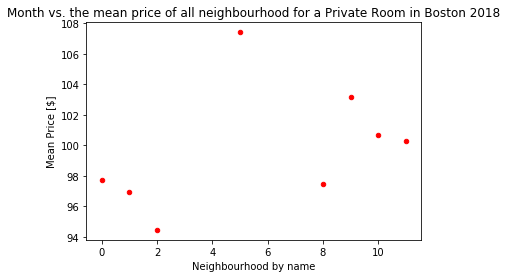

,month,month_cat,max,min,mean,median
0,4,0,999.0,0.0,97.690993,92.289773
4,5,8,999.0,0.0,97.429949,86.250000
3,7,5,872.0,0.0,107.396698,94.898876
1,8,1,872.0,0.0,96.929846,89.000000
7,9,11,872.0,0.0,100.267816,93.333333
6,10,10,872.0,0.0,100.638517,97.125000
5,11,9,872.0,0.0,103.149357,99.140523
2,12,2,900.0,0.0,94.457323,84.982226


In [50]:
#Using the month_stats function on the dataframe of private rooms in Boston in 2018
df_2018_month_proom = month_stats(df_Boston_proom_2018);

#Plotting the prices of each month of private rooms in Boston in 2018
df_2018_month_proom.plot(kind='scatter',x='month_cat',y='mean',color='red')
ax = plt.gca()
plt.title("Month vs. the mean price of all neighbourhood for a Private Room in Boston 2018");
ax.set_xlabel('Neighbourhood by name');
ax.set_ylabel('Mean Price [$]');
plt.show()

#We will sort them by the month to start in january
df_2018_month_proom = df_2018_month_proom.sort_values(by='month')
df_2018_month_proom.head(12)

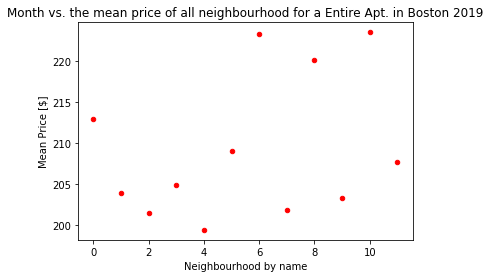

,month,month_cat,max,min,mean,median
4,1,4,999.0,0.0,212.992229,199.456265
3,2,3,999.0,0.0,219.589692,204.921053
7,3,7,999.0,0.0,214.476553,201.893277
1,4,0,999.0,0.0,230.253434,212.991304
8,5,8,999.0,0.0,229.059026,220.132298
6,6,6,999.0,0.0,242.643392,223.250000
5,7,5,999.0,0.0,234.000481,209.000596
2,8,1,999.0,10.0,227.074528,203.988449
11,9,11,999.0,10.0,230.762707,207.771119
10,10,10,999.0,15.0,246.762603,223.500000


In [51]:
#Using the month_stats function on the dataframe of entire apt. in Boston in 2019
df_2019_month_entire = month_stats(df_Boston_entire_2019);

#Plotting the prices of each month of entire apt. in Boston in 2019
df_2019_month_entire.plot(kind='scatter',x='month_cat',y='median',color='red')
ax = plt.gca()
plt.title("Month vs. the mean price of all neighbourhood for a Entire Apt. in Boston 2019");
ax.set_xlabel('Neighbourhood by name');
ax.set_ylabel('Mean Price [$]');
plt.show()

#We will sort them by the month to start in january
df_2019_month_entire = df_2019_month_entire.sort_values(by='month')
df_2019_month_entire.head(40)

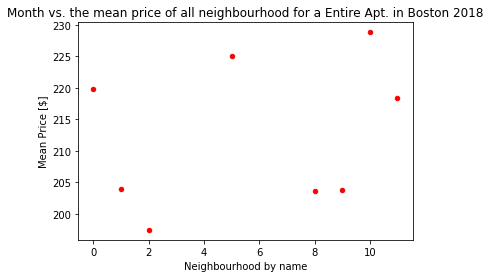

,month,month_cat,max,min,mean,median
0,4,0,999.0,0.0,218.382923,219.830357
4,5,8,995.0,0.0,210.565614,203.565306
3,7,5,995.0,0.0,225.972267,225.115702
1,8,1,999.0,0.0,223.009037,203.907563
7,9,11,995.0,0.0,224.330139,218.444444
6,10,10,999.0,0.0,232.696345,228.821429
5,11,9,999.0,0.0,213.728271,203.694594
2,12,2,999.0,0.0,196.608676,197.440940


In [52]:
#Using the month_stats function on the dataframe of entire apt. in Boston in 2019
df_2018_month_entire = month_stats(df_Boston_entire_2018);

#Plotting the prices of each month of entire apt. in Boston in 2019
df_2018_month_entire.plot(kind='scatter',x='month_cat',y='median',color='red')
ax = plt.gca()
plt.title("Month vs. the mean price of all neighbourhood for a Entire Apt. in Boston 2018");
ax.set_xlabel('Neighbourhood by name');
ax.set_ylabel('Mean Price [$]');
plt.show()

#We will sort them by the month to start in january
df_2018_month_entire = df_2018_month_entire.sort_values(by='month')
df_2018_month_entire.head(40)

In [53]:
#To generate a model, all data farms that save the relationship between price and 
#month for each room type are transferred to a data frame.

df_Boston_month_max = pd.DataFrame([], columns = []) 
df_Boston_month_max.insert(0,'Month',df_2019_month_proom['month'])
df_Boston_month_max.insert(1,'Boston_proom_2019_mean',df_2019_month_proom['mean'])
df_Boston_month_max.insert(2,'Boston_proom_2019_median',df_2019_month_proom['median'])

df_Boston_month_max.insert(3,'Boston_proom_2018_mean',df_2018_month_proom['mean'])
df_Boston_month_max.insert(4,'Boston_proom_2018_median',df_2018_month_proom['median'])

df_Boston_month_max.insert(5,'Boston_entire_2019_mean',df_2019_month_entire['mean'])
df_Boston_month_max.insert(6,'Boston_entire_2019_median',df_2019_month_entire['median'])

df_Boston_month_max.insert(7,'Boston_entire_2018_mean',df_2018_month_entire['mean'])
df_Boston_month_max.insert(8,'Boston_entire_2018_median',df_2018_month_entire['median'])

df_Boston_month_max.head(12)

#Before we can start modeling, we have to go into the N / A. Our starting point is that we 
#enter the mean value of the column for all missing numbers. 
#This is understandable in the first step, especially when creating a model 
#that should predict the average price.

,Month,Boston_proom_2019_mean,Boston_proom_2019_median,Boston_proom_2018_mean,Boston_proom_2018_median,Boston_entire_2019_mean,Boston_entire_2019_median,Boston_entire_2018_mean,Boston_entire_2018_median
4,1,102.620907,86.888889,97.429949,86.250000,212.992229,199.456265,210.565614,203.565306
3,2,99.848418,86.888889,107.396698,94.898876,219.589692,204.921053,225.972267,225.115702
7,3,90.196332,72.598214,100.267816,93.333333,214.476553,201.893277,224.330139,218.444444
1,4,105.191657,98.545455,96.929846,89.000000,230.253434,212.991304,223.009037,203.907563
8,5,103.931602,84.042654,NaN,NaN,229.059026,220.132298,NaN,NaN
6,6,99.707757,98.000000,100.638517,97.125000,242.643392,223.250000,232.696345,228.821429
5,7,107.075967,80.881517,103.149357,99.140523,234.000481,209.000596,213.728271,203.694594
2,8,111.198371,95.250000,94.457323,84.982226,227.074528,203.988449,196.608676,197.440940
11,9,94.375201,82.899390,NaN,NaN,230.762707,207.771119,NaN,NaN
10,10,88.474784,75.000000,NaN,NaN,246.762603,223.500000,NaN,NaN


In [54]:
#The following lines enter the mean value in each split of the data frame in 
#which numbers are missing or N / A appear.
#Mean function
fill_mean = lambda col: col.fillna(col.mean())
#Fill the mean
df_Boston_month_max= df_Boston_month_max.apply(fill_mean, axis=0)
df_Boston_month_max.head(12)

,Month,Boston_proom_2019_mean,Boston_proom_2019_median,Boston_proom_2018_mean,Boston_proom_2018_median,Boston_entire_2019_mean,Boston_entire_2019_median,Boston_entire_2018_mean,Boston_entire_2018_median
4,1,102.620907,86.888889,97.429949,86.250000,212.992229,199.456265,210.565614,203.565306
3,2,99.848418,86.888889,107.396698,94.898876,219.589692,204.921053,225.972267,225.115702
7,3,90.196332,72.598214,100.267816,93.333333,214.476553,201.893277,224.330139,218.444444
1,4,105.191657,98.545455,96.929846,89.000000,230.253434,212.991304,223.009037,203.907563
8,5,103.931602,84.042654,99.745062,92.127466,229.059026,220.132298,218.161659,212.602542
6,6,99.707757,98.000000,100.638517,97.125000,242.643392,223.250000,232.696345,228.821429
5,7,107.075967,80.881517,103.149357,99.140523,234.000481,209.000596,213.728271,203.694594
2,8,111.198371,95.250000,94.457323,84.982226,227.074528,203.988449,196.608676,197.440940
11,9,94.375201,82.899390,99.745062,92.127466,230.762707,207.771119,218.161659,212.602542
10,10,88.474784,75.000000,99.745062,92.127466,246.762603,223.500000,218.161659,212.602542


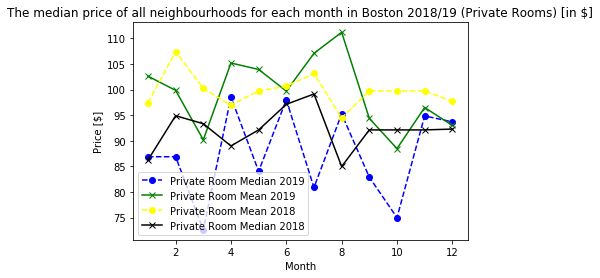

In [55]:
#In the next picture we show the mean and median of all neighborhoods in each month in 2018 and 2019 in the course.
x_values_2019 = df_Boston_month_max['Month'] # assign the column month as x_value for the next steps
y_values_proom_2019_median = df_Boston_month_max['Boston_proom_2019_median'] # assign the median as y
y_values_proom_2019_mean = df_Boston_month_max['Boston_proom_2019_mean'] # assign the mean as y
y_values_proom_2018_median = df_Boston_month_max['Boston_proom_2018_median'] # assign the median as y
y_values_proom_2018_mean = df_Boston_month_max['Boston_proom_2018_mean'] # assign the mean as y

#plotting the data
plt.plot(x_values_2019, y_values_proom_2019_median, marker='o', linestyle='--', color='blue', label='Private Room Median 2019') 
plt.plot(x_values_2019, y_values_proom_2019_mean, marker='x', linestyle='-', color='green', label='Private Room Mean 2019')
plt.plot(x_values_2019, y_values_proom_2018_mean, marker='o', linestyle='--', color='yellow', label='Private Room Mean 2018') 
plt.plot(x_values_2019, y_values_proom_2018_median, marker='x', linestyle='-', color='black', label='Private Room Median 2018')
plt.title("The median price of all neighbourhoods for each month in Boston 2018/19 (Private Rooms) [in $]");
ax = plt.gca()
plt.legend()
ax.set_xlabel('Month');
ax.set_ylabel('Price [$]');
plt.show()

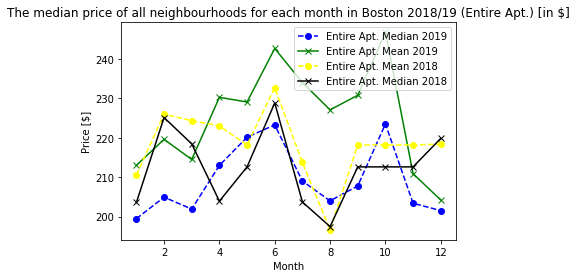

In [56]:
#In the next picture we show the mean and median of all neighborhoods in each month in 2018 and 2019 in the course.
x_values_2019 = df_Boston_month_max['Month'] # assign the column month as x_value for the next steps
y_values_entire_2019_median = df_Boston_month_max['Boston_entire_2019_median'] # assign the median as y
y_values_entire_2019_mean = df_Boston_month_max['Boston_entire_2019_mean'] # assign the mean as y
y_values_entire_2018_median = df_Boston_month_max['Boston_entire_2018_median'] # assign the median as y
y_values_entire_2018_mean = df_Boston_month_max['Boston_entire_2018_mean'] # assign the mean as y

#plotting the data
plt.plot(x_values_2019, y_values_entire_2019_median, marker='o', linestyle='--', color='blue', label='Entire Apt. Median 2019') 
plt.plot(x_values_2019, y_values_entire_2019_mean, marker='x', linestyle='-', color='green', label='Entire Apt. Mean 2019')
plt.plot(x_values_2019, y_values_entire_2018_mean, marker='o', linestyle='--', color='yellow', label='Entire Apt. Mean 2018') 
plt.plot(x_values_2019, y_values_entire_2018_median, marker='x', linestyle='-', color='black', label='Entire Apt. Median 2018')
plt.title("The median price of all neighbourhoods for each month in Boston 2018/19 (Entire Apt.) [in $]");
ax = plt.gca()
plt.legend()
ax.set_xlabel('Month');
ax.set_ylabel('Price [$]');
plt.show()

In [90]:
#CRISProcess | Data Modeling
#To model the price behaviour we will use a linear approach by a linear regression model
#In the first step, we will use all values we have got and not generate a test set

#Scaling the data for the modeling
X_2019 = x_values_2019.values.reshape(-1, 1)

#We will use the median for our model
Y_proom_2019 = y_values_proom_2019_median.values.reshape(-1, 1)

#We will start with a linear model to do the approach of the
#price prediction - set and fit the model
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_2019, Y_proom_2019)  # perform linear regression

#Now with have got a lineare model "linear_regressor" and we would
#like to predict the price
Y_pred_proom_2019 = linear_regressor.predict(X_2019)  # make predictions

r_sq_proom_2019 = linear_regressor.score(X_2019, Y_proom_2019) # feedback of the model quality by the score of the model
print('coefficient of determination:', r_sq_proom_2019 )
print('intercept:', linear_regressor.intercept_) # printing the intercept of the model
intercept: 85.15075943
print('slope:', linear_regressor.coef_) # printing the regression coefficients

coefficient of determination: 0.02151652021443351
intercept: [85.15075943]
slope: [[0.35570109]]


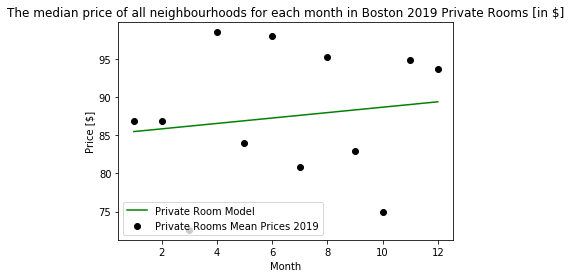

In [91]:
#Here we plot the values vs. the model
plt.scatter(X_2019, Y_proom_2019, color='black', label='Private Rooms Mean Prices 2019')
plt.plot(X_2019, Y_pred_proom_2019, color='green', label='Private Room Model')
plt.title("The median price of all neighbourhoods for each month in Boston 2019 Private Rooms [in $]");
ax = plt.gca()
plt.legend()
ax.set_xlabel('Month');
ax.set_ylabel('Price [$]');
plt.show()

In [92]:
#CRISProcess | Data Modeling
#Now we will to a linear approach to predict the prices and spilt the
#dataset into test and training data

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_2019, Y_proom_2019, test_size = 0.3, shuffle=False)

#Fitting the model
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predicting the price
y_test_preds = lm_model.predict(X_2019)

#Training score
r_sq_train = linear_regressor.score(X_train, y_train)

#Test score
r_sq_test = linear_regressor.score(X_test, y_test)

print('coefficient of determination - Train:', r_sq_train)
print('coefficient of determination - Test:', r_sq_test)
print('intercept:', lm_model.intercept_) # printing the intercept of the model
intercept: 83.05515896
print('slope:', lm_model.coef_) # printing the regression coefficients

coefficient of determination - Train: 0.028879796347060505
coefficient of determination - Test: -0.010030499986653174
intercept: [83.05515896]
slope: [[1.07373182]]


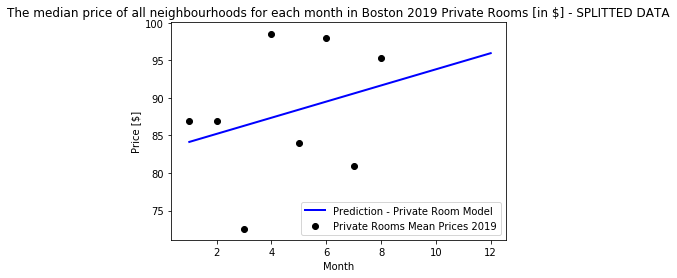

In [93]:
#CRISProcess | Evaluation
#Here we plot the values vs. the model
#Selection of the model that best fulfills the task. Careful comparison with the task.
y_test_preds = lm_model.predict(X_2019)
plt.plot(X_2019, y_test_preds, color='blue', label='Prediction - Private Room Model', linewidth=2)
plt.scatter(X_train, y_train, color='black', label='Private Rooms Mean Prices 2019')
plt.title("The median price of all neighbourhoods for each month in Boston 2019 Private Rooms [in $] - SPLITTED DATA");
ax = plt.gca()
plt.legend()
ax.set_xlabel('Month');
ax.set_ylabel('Price [$]');
plt.show()

In [94]:
#Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(r_sq_train, r_sq_test))

The rsquared on the training data was 0.028879796347060505.  The rsquared on the test data was -0.010030499986653174.


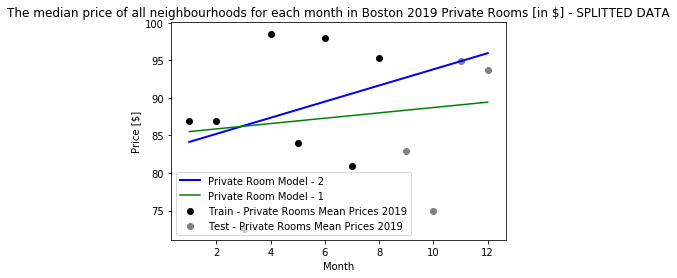

In [95]:
#Here we plot the values vs. the model
y_test_preds = lm_model.predict(X_2019)
plt.plot(X_2019, y_test_preds, color='blue', label='Private Room Model - 2', linewidth=2)
plt.plot(X_2019, Y_pred_proom_2019, color='green', label='Private Room Model - 1')
plt.scatter(X_train, y_train, color='black', label='Train - Private Rooms Mean Prices 2019')
plt.scatter(X_test, y_test, color='gray', label='Test - Private Rooms Mean Prices 2019')
plt.title("The median price of all neighbourhoods for each month in Boston 2019 Private Rooms [in $] - SPLITTED DATA");
ax = plt.gca()
plt.legend()
ax.set_xlabel('Month');
ax.set_ylabel('Price [$]');
plt.show()

In [99]:
#CRISProcess | Evaluation
#In the final step we will use the mean values to predict and compare
#the price

#Scaling the data for the modeling
X_2019 = x_values_2019.values.reshape(-1, 1)

#We will use the median for our model
Y_proom_2019_mean = y_values_proom_2019_mean.values.reshape(-1, 1)

#Split into train and test
X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(X_2019, Y_proom_2019_mean, test_size = 0.3, shuffle=False)

#Fitting the model
lm_model_mean = LinearRegression(normalize=True) # Instantiate
lm_model_mean.fit(X_train_mean, y_train_mean) #Fit

#Predicting the price
y_test_preds_mean = lm_model.predict(X_2019)

#Training score
r_sq_train_mean = linear_regressor.score(X_train_mean, y_train_mean)

#Test score
r_sq_test_mean = linear_regressor.score(X_test_mean, y_test_mean)

print('coefficient of determination - Train:', r_sq_train_mean)
print('coefficient of determination - Test:', r_sq_test_mean)
print('intercept:', lm_model_mean.intercept_) # printing the intercept of the model
intercept: 83.05515896
print('slope:', lm_model_mean.coef_) # printing the regression coefficients

coefficient of determination - Train: -7.123327092054227
coefficient of determination - Test: -2.0207029229471685
intercept: [95.85775782]
slope: [[1.46969304]]


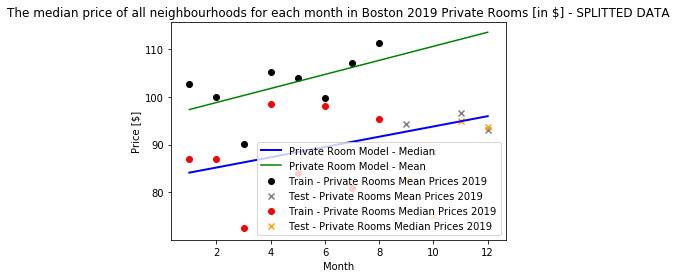

In [121]:
######################################################################################################################
#######################################The third business question####################################################
#Is it possible to derive the price from the previous data based on the room type and month? 
#The customer behavior and the market situation can be derived from this.
#Is it possible to predict the price development for a room type?
#Questions of a marketing department could be: In which district 
#should we advertise more or what types of rooms should we also market social platforms more?

#Here we plot the values vs. the model
y_test_preds_mean = lm_model_mean.predict(X_2019)
plt.plot(X_2019, y_test_preds, color='blue', label='Private Room Model - Median', linewidth=2)
plt.plot(X_2019, y_test_preds_mean, color='green', label='Private Room Model - Mean')

plt.scatter(X_train_mean, y_train_mean, color='black', marker='o',  label='Train - Private Rooms Mean Prices 2019')
plt.scatter(X_test_mean, y_test_mean, color='gray', marker='x',  label='Test - Private Rooms Mean Prices 2019')

plt.scatter(X_train, y_train, color='red', marker='o',  label='Train - Private Rooms Median Prices 2019')
plt.scatter(X_test, y_test, color='orange', marker='x',  label='Test - Private Rooms Median Prices 2019')

plt.title("The median price of all neighbourhoods for each month in Boston 2019 Private Rooms [in $] - SPLITTED DATA");
ax = plt.gca()
plt.legend()
ax.set_xlabel('Month');
ax.set_ylabel('Price [$]');
plt.show()

In [ ]:
#We can see that we have implemented two models for price prediction for private rooms. 
#With one model we calculate the average price of a room and with the other the median of the price of a room.

#In summary, we answered three questions in the course of your Juyper notebook and finally 
#developed two price models for private rooms in Boston.